# Notebook 3: Temperature Anomaly analysis of Telangana
This notebook contains temperature anomalies for the state of Telagana. 

Importing necessary libraries

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
!pip install netCDF4 

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

In [1]:
#Import Global Anomaly data
global_anomalies = xr.open_dataset("monthlyanomaly.nc")

In [2]:
from shapely.geometry import mapping

#Clip the anomaly data obtained in the Notebook 2 for Telangana
geodf = gpd.read_file("C:/Users/007sh/Desktop/UNDP/telangana_shapefile/Telangana.shp")
global_anomalies.rio.write_crs("epsg:4326", inplace=True)
xds = rxr.open_rasterio("telangana_shapefile/Telangana.shp")
telangana_anomalies = global_anomalies.rio.clip(geodf.geometry.apply(mapping), geodf.crs)

In [3]:
#Get Temperature anomalies of Telangana from 1951-2022 
tel_anomaly = telangana_anomalies.mean(("longitude", "latitude"), skipna=True)

In [25]:
tel = xr.open_dataset("telanganaanomaly.nc")
tel = tel.__xarray_dataarray_variable__
from itertools import chain
data = []

#preparing the data for deviance analysis
for i in range (0, len(tel)): 
    x = np.array(tel[i])
    monthlydatapixel = list(chain.from_iterable(x))
    data.append(monthlydatapixel) 
    
df = pd.DataFrame(data)
df = df.loc[:, (df != 0).any(axis=0)] #remove all 0 values
df = df.loc[:, (df != -999).any(axis=0)] #remove all -999 values
df = df.T.reset_index(drop=True).T 
df = df.fillna(0)
df.to_csv("telanomalies.csv")

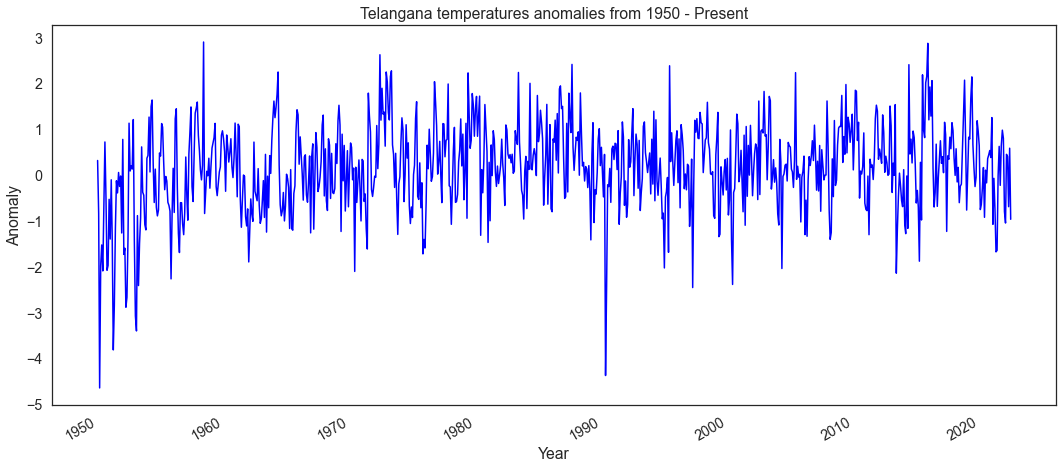

In [28]:
#PLot of Temperature anomalies and Creating a trend line to understand better 
f, ax = plt.subplots(figsize=(18, 7))

tel_anomaly.plot(hue='lat',ax=ax,color="purple")

plt.xlabel('Year')
plt.ylabel('Anomaly')
plt.title('Telangana temperatures anomalies from 1950 - Present')
plt.savefig('TelanganaTempAnomalies.png')

In [33]:
#Saving Telangana anomaly data for future use
telangana_anomalies[870].to_netcdf(path="telanganaanomaly_july2022.tif")

In [39]:
#Import a generated image and visualize it.
from osgeo import gdal
import matplotlib.pyplot as plt
from osgeo import osr

spatref = osr.SpatialReference()
spatref.ImportFromEPSG(4326)
crs_wkt = spatref.ExportToWkt()

dataset = gdal.Open('telanganaanomaly_july2022.tif', gdal.GA_ReadOnly) 
dataset.SetProjection(crs_wkt)
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()
geotransform = dataset.GetGeoTransform()

originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  dataset.RasterXSize
rows =  dataset.RasterYSize

projection = dataset.GetProjection()

finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

extentArray = [originX,finalX,originY,finalY]

plt.figure(figsize=(8,8))

im = plt.imshow(arr, cmap= "RdYlGn_r", extent=extentArray, origin="lower")
plt.colorbar(im, fraction=0.03)
plt.gca().invert_yaxis()

plt.rcParams.update({'font.size': 13})
plt.title("Temperature anomalies in Telangana July 2022\n")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
print(" ")
plt.show()